In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cosmoprimo import Fourier, Cosmology, PowerSpectrumBAOFilter, fiducial
from scipy.optimize import minimize
from src.temp import tree_level_b00, Bi0
import src.utils as ut

In [2]:
plt.rc('font', family='Times', size=15)

In [3]:
from scipy.interpolate import interp1d

In [ ]:
# 1. try the mean of Abacus power spectrum as the input pk for bispectrum template
# maybe need to use a linear/power law extrapolation for low-k
# 2. check Abacus fid cosmological parameters

In [4]:
bs = ut.get_bispectra('LRGz0')
ps = ut.get_powerspectra('LRGz0')

# k1, k2, k3 = bs.k[700:, :].T
# b_obs = bs.b[:, 700:].mean(axis=0)

k1, k2, k3 = bs.k[:, :].T
b_obs = bs.b[:, :].mean(axis=0)

tracer: LRGz0
tracer: LRGz0


In [5]:
engine = 'camb'
abacus_cosmo = fiducial.AbacusSummit_params()[0]

#cosmo = Cosmology(engine=engine, **dict(Omega0_m=0.32, kmax_pk=101.))
cosmo = Cosmology(engine=engine, **fiducial.AbacusSummit_params(0))
fo = Fourier(cosmo, engine=engine, )
print('fsigma8 is', fo.sigma8_m)

pk = fo.pk_interpolator()
pknow_wallish = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
k = np.logspace(-4, 2, 10000)

fsigma8 is 0.8077880588827031


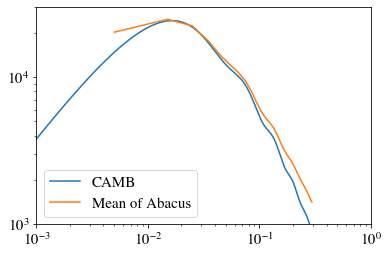

In [6]:
plt.plot(k, pk(k, z=0.0), label=engine.upper())
# plt.plot(k, pknow_wallish(k, z=0.0), label='Smooth (Wallish)')

plt.plot(ps.k, 1.6e2*ps.p.mean(axis=0), label='Mean of Abacus')

plt.xlim(1.0e-3, 1.0e0)
plt.ylim(1.0e3, 3.0e4)

plt.legend()
plt.yscale('log')
plt.xscale('log')

In [7]:
pk_1d = lambda k:pk(k, z=0.)
pknow_1d = lambda k:pknow_wallish(k, z=0.)

pk_1d_mock = interp1d(ps.k, ps.p.mean(axis=0), kind='quadratic', bounds_error=True)

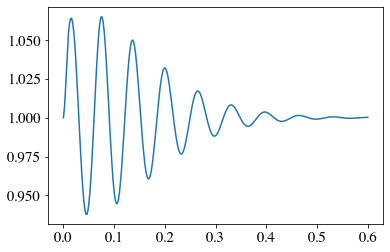

In [8]:
kg = np.linspace(1.0e-6, 0.6, num=300)
plt.plot(kg, pk_1d(kg)/pknow_1d(kg))

In [9]:
def loss_smooth(params):
    b1, b2, f, s0, s1 = params
    b00 = tree_level_b00(k1, k2, k3, b1, b2, f, s0, s1, pknow_1d)  
    return ((b00-b_obs)**2).sum()
    
def loss(params, pk_1d=None):
    b1, b2, f, s0, s1 = params
    b00 = tree_level_b00(k1, k2, k3, b1, b2, f, s0, s1, pk_1d)   
    return ((b00 - b_obs)**2).sum() + (abs(b00 - b_obs)).sum()

def loss2(params):
    b1, b2, f, s0, s1 = params
    b00 = Bi0(k1, k2, k3, b1, b2, f, s0, s1, pk_1d)   
    return ((b00 - b_obs)**2).sum()

In [10]:
res = minimize(loss, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell', args=(pk_1d))
res_mock = minimize(loss, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell', args=(pk_1d_mock))#, method='Powell')
# res_smooth = minimize(loss_smooth, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell')#, method='Powell')

In [14]:
# Y00=np.sqrt(1/np.pi)
# b00_jay = np.array(Bi0(k1, k2, k3, *res.x, pk_1d))/Y00
b00_lado = tree_level_b00(k1, k2, k3, *res.x, pk_1d)
b00_lado_mock = tree_level_b00(k1, k2, k3, *res_mock.x, pk_1d_mock)
b00_lado_s = tree_level_b00(k1, k2, k3, *res.x, pknow_1d)

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(np.arange(0, 2600), (b00_jay)/b00_lado)
# plt.ylim(0.99, 1.010)
# plt.xlabel('Triangle index')
# plt.ylabel('Jay/Lado')

In [90]:
b00_lado, b00_lado_mock

(array([217677.28053496, 308428.31406594, 278369.14948883, ...,
          3396.25986717,   3348.88568919,   3301.54726841]),
 array([342776.89101568, 470293.58088352, 411721.34727093, ...,
          -590.7125029 ,   -733.84103564,   -875.32177388]))

Text(0.5, 0, 'Triangle index')

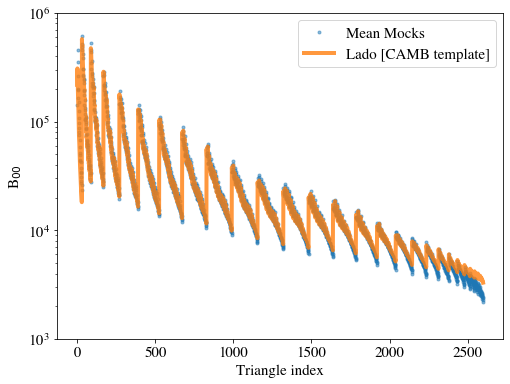

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(b_obs, label='Mean Mocks', marker='.', ls='None', alpha=0.5)
plt.plot(b00_lado, label='Lado [CAMB template]', lw=4, alpha=0.8)
# plt.plot(b00_lado_mock, label='Lado [Mean Pk template]', lw=1, alpha=0.7)
# plt.plot(b00_jay, label='Jayashree', ls='-', alpha=0.6)

plt.semilogy()
plt.ylim(1.0e3, 1.0e6)
plt.legend()
plt.ylabel(r'B$_{00}$')
plt.xlabel('Triangle index')

Text(0.5, 0, 'Triangle index')

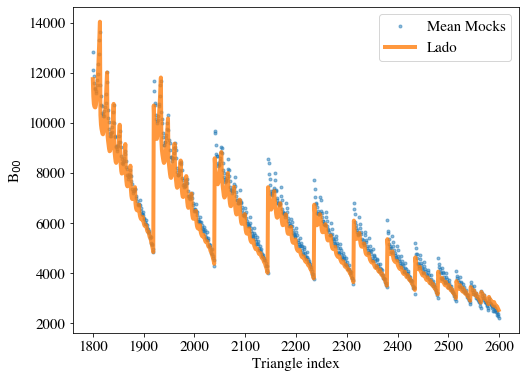

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1800, 2600), b_obs[1800:], label='Mean Mocks', marker='.', ls='None', alpha=0.5)
plt.plot(np.arange(1800, 2600), b00_lado[1800:], label='Lado', lw=4, alpha=0.8)
# plt.plot(b00_jay, label='Jayashree', ls='-', alpha=0.6)

# plt.semilogy()
plt.legend()
plt.ylabel(r'B$_{00}$')
plt.xlabel('Triangle index')

Text(0.5, 0, 'k1')

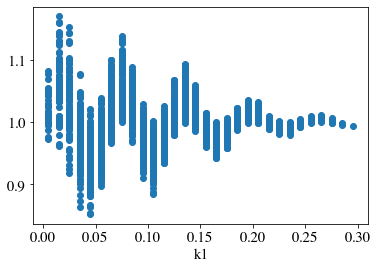

In [20]:
plt.scatter(bs.k[:, 0], b00_lado/b00_lado_s)
plt.xlabel('k1')

Text(0.5, 0, 'index')

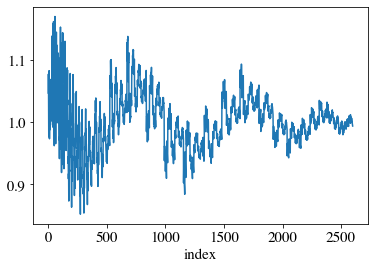

In [21]:
plt.plot(b00_lado/b00_lado_s)
plt.xlabel('index')

(0.8, 1.2)

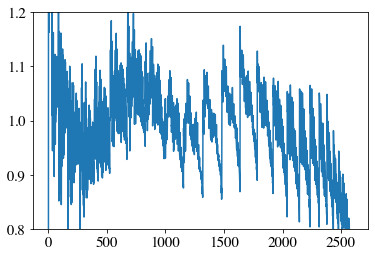

In [24]:
plt.plot(b_obs/b00_lado_s)
plt.ylim(0.8, 1.2)

Text(0.5, 0, 'Triangle index')

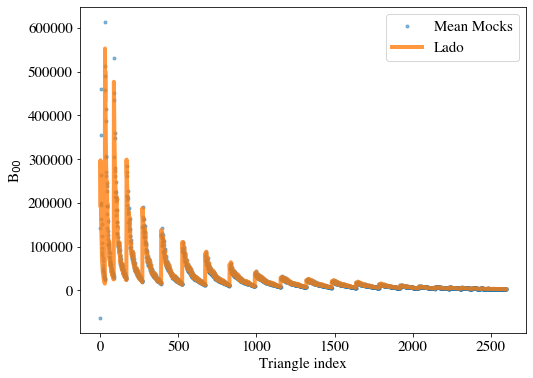

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(b_obs, label='Mean Mocks', marker='.', ls='None', alpha=0.5)
plt.plot(b00_lado, label='Lado', lw=4, alpha=0.8)
# plt.plot(b00_jay, label='Jayashree', ls='-', alpha=0.6)

# plt.semilogy()
plt.legend()
plt.ylabel(r'B$_{00}$')
plt.xlabel('Triangle index')

In [36]:
Y00/2

0.28209479177387814

In [17]:
0.5/(np.pi**0.5)

0.28209479177387814

In [24]:
-1*b00_jay

[]

[]

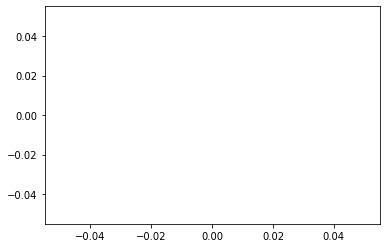

In [21]:
plt.plot()

In [11]:
res2 = minimize(loss2, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell')#, method='Powell')

KeyboardInterrupt: 

Text(0, 0.5, 'B00')

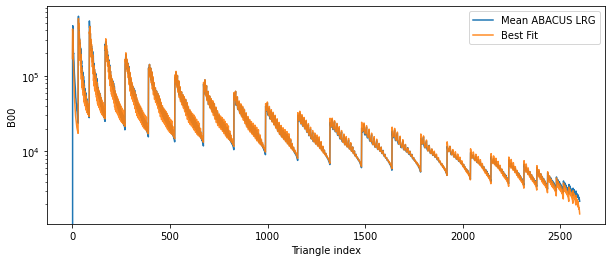

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(bs.b.mean(axis=0), label='Mean ABACUS LRG')
plt.plot(tree_level_b00(*bs.k.T, *res.x, pk_1d), alpha=0.9, label='Best Fit')
# plt.plot(model(*res.x, pknow_1d), alpha=0.9, label='Best Fit [smooth]')
plt.semilogy()
plt.legend()
plt.xlabel('Triangle index')
plt.ylabel('B00')

Text(0, 0.5, 'B00')

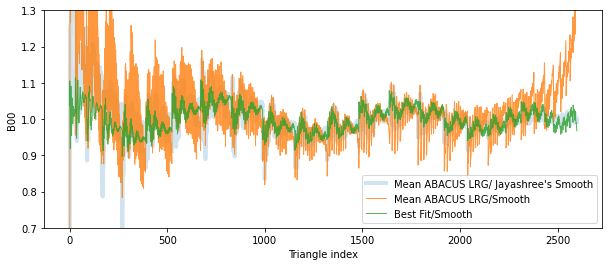

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(bs.b.mean(axis=0)/bs.b_smooth.mean(axis=0), label="Mean ABACUS LRG/ Jayashree's Smooth", alpha=0.2, lw=4)
plt.plot(bs.b.mean(axis=0)/tree_level_b00(*bs.k.T, *res.x, pknow_1d), label="Mean ABACUS LRG/Smooth", alpha=0.8, lw=1)
plt.plot(tree_level_b00(*bs.k.T, *res.x, pk)/tree_level_b00(*bs.k.T, *res.x, pknow_1d), alpha=0.8, label='Best Fit/Smooth', lw=1)
# plt.semilogy()
plt.ylim(0.7, 1.3)
plt.legend()
plt.xlabel('Triangle index')
plt.ylabel('B00')

In [ ]:
# 1. choose a power spectrum template that is close to ABACUS
#     1.2 try different set of CAMB parameters 
#

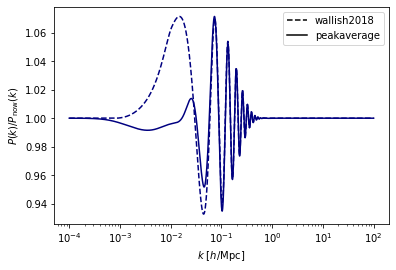

In [13]:
# Several engines are available for the power spectrum, but wallish2018 and peakaverage seem the most accurate one
# peakaverage has smooth dependence on cosmological parameters (useful for taking derivatives)
# Note one can also provide a 1D power spectrum interpolator
pknow_wallish = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pknow_brieden = PowerSpectrumBAOFilter(pk, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo).smooth_pk_interpolator()
k = np.logspace(-4, 2, 10000)
z = [0.0, ]#, np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
plt.plot([], [], linestyle='--', color='k', label='wallish2018')
plt.plot([], [], linestyle='-', color='k', label='peakaverage')
for zz, color in zip(z, colors):
    plt.plot(k, pk(k, z=zz) / pknow_wallish(k, z=zz), color=color, linestyle='--')
    plt.plot(k, pk(k, z=zz) / pknow_brieden(k, z=zz), color=color, linestyle='-')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)/P_{\mathrm{now}}(k)$')
#plt.xlim(, 1)
plt.xscale('log')
plt.legend()
plt.show()

[]

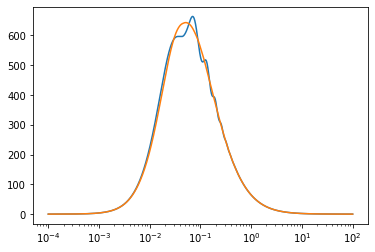

In [20]:
plt.plot(k, k*pk(k, z=zz))
plt.plot(k, k*pknow_wallish(k, z=zz))
plt.semilogx()

In [1]:
import numpy as np
import fftlog

In [2]:
import hankl

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from scipy.interpolate import interp1d

In [5]:
import camb

In [6]:
from camb import model, initialpower

In [7]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)

pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.0], kmax=2000)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)

In [8]:
k = np.logspace(-3, 3, 2**10)

In [9]:
PK = results.get_matter_power_interpolator(k_hunit=True)
pk = PK.P(0.0, k)#/1.42e2

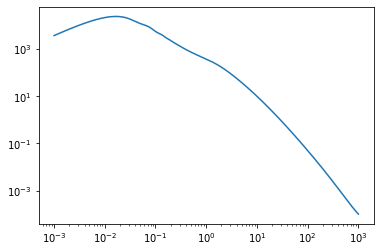

In [10]:
plt.loglog(k, pk)

In [11]:
r, xi = hankl.P2xi(k, pk, l=0)
xi = xi.real

In [88]:
def xi_model(r, p):
    return (p[0]*r*r + p[1]*r + p[6]*r*r*r)*np.exp(-r*r) + p[2]/r + p[3]/(r*r) + p[4] + p[5]/(r*r*r)

def loss(p, r, xi_obs):
    xi_m = xi_model(r, p)
    return ((xi_m - xi_obs)**2).sum()

In [13]:
from scipy.optimize import minimize

In [79]:
is_g = (r>20) & (r<50) 
is_g |= (r>150) & (r<200)

In [89]:
res = minimize(loss, [1., 1., 1., 1., 1., 1., 1., 1., 1.], args=(r[is_g], xi[is_g]))

(10.0, 400.0)

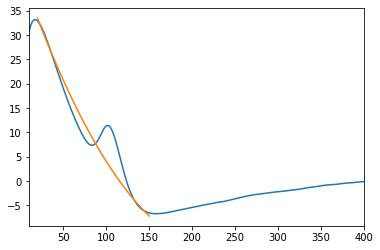

In [90]:
r_g = np.linspace(20, 150)
plt.plot(r, r**2*xi)
plt.plot(r_g, r_g**2*xi_model(r_g, res.x))
plt.xlim(10, 400)
# plt.ylim(-1, 2)